In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from footprint import *
from tno_models import trojan, plutino, twotino
init_notebook_mode(connected=True)
planets = load('de423.bsp')
plotly.tools.set_credentials_file(username='sevenlin123', api_key='vhjhhsCHepMx5oQGJPEp')

[#################################] 100% de422.bsp


In [2]:
#p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0)
p = plutino(size = 5000, mjd=57023)

(array([ 239.,  253.,  232.,  248.,  225.,  237.,  250.,  250.,  281.,
         282.,  252.,  227.,  245.,  228.,  270.,  265.,  267.,  288.,
         214.,  240.]),
 array([ 39.25019875,  39.27018169,  39.29016464,  39.31014758,
         39.33013053,  39.35011347,  39.37009641,  39.39007936,
         39.4100623 ,  39.43004525,  39.45002819,  39.47001113,
         39.48999408,  39.50997702,  39.52995997,  39.54994291,
         39.56992586,  39.5899088 ,  39.60989174,  39.62987469,  39.64985763]),
 <a list of 20 Patch objects>)

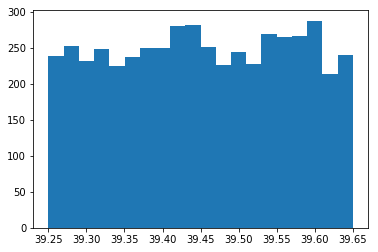

In [3]:
plt.hist(p.a, bins = 20)

(array([  23.,   54.,   91.,  158.,  295.,  409.,  535.,  704.,  706.,
         594.,  523.,  378.,  268.,  140.,   63.,   24.,   23.,    3.,
           1.,    1.]),
 array([ 0.00194362,  0.0225871 ,  0.04323057,  0.06387404,  0.08451752,
         0.10516099,  0.12580447,  0.14644794,  0.16709141,  0.18773489,
         0.20837836,  0.22902184,  0.24966531,  0.27030878,  0.29095226,
         0.31159573,  0.3322392 ,  0.35288268,  0.37352615,  0.39416963,
         0.4148131 ]),
 <a list of 20 Patch objects>)

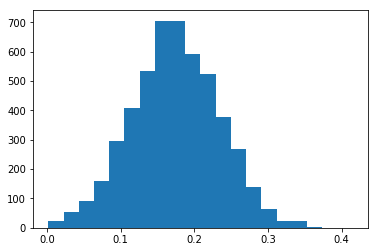

In [4]:
plt.hist(p.e, bins = 20)

(array([ 248.,  672.,  878.,  876.,  768.,  598.,  383.,  252.,  145.,
          78.,   43.,   30.,   14.,    4.,    0.,    3.,    0.,    0.,
           0.,    1.]),
 array([  0.14577957,   3.82186756,   7.49795555,  11.17404353,
         14.85013152,  18.52621951,  22.20230749,  25.87839548,
         29.55448346,  33.23057145,  36.90665944,  40.58274742,
         44.25883541,  47.9349234 ,  51.61101138,  55.28709937,
         58.96318736,  62.63927534,  66.31536333,  69.99145132,  73.6675393 ]),
 <a list of 20 Patch objects>)

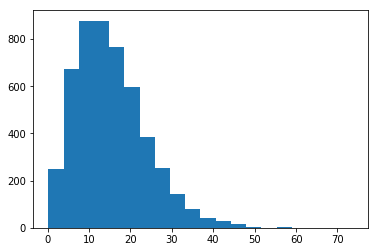

In [5]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([  2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   9.00000000e+00,   1.40000000e+01,
          2.80000000e+01,   3.50000000e+01,   5.20000000e+01,
          8.30000000e+01,   1.19000000e+02,   2.04000000e+02,
          3.35000000e+02,   5.13000000e+02,   6.97000000e+02,
          1.12900000e+03,   1.75900000e+03]),
 array([ 4.16547135,  4.38219455,  4.59891774,  4.81564094,  5.03236413,
         5.24908733,  5.46581052,  5.68253372,  5.89925692,  6.11598011,
         6.33270331,  6.5494265 ,  6.7661497 ,  6.98287289,  7.19959609,
         7.41631929,  7.63304248,  7.84976568,  8.06648887,  8.28321207,
         8.49993527]),
 <a list of 20 Patch objects>)

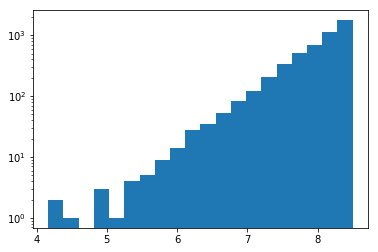

In [6]:
plt.yscale('log', nonposy='clip')
plt.hist(p.H, bins = 20)

(array([   1.,    2.,    1.,    2.,    2.,    9.,   11.,   31.,   42.,
          98.,  154.,  306.,  504.,  656.,  819.,  750.,  791.,  562.,
         230.,   22.]),
 array([ 19.89888498,  20.20945582,  20.52002666,  20.83059749,
         21.14116833,  21.45173917,  21.76231   ,  22.07288084,
         22.38345167,  22.69402251,  23.00459335,  23.31516418,
         23.62573502,  23.93630585,  24.24687669,  24.55744753,
         24.86801836,  25.1785892 ,  25.48916004,  25.79973087,  26.11030171]),
 <a list of 20 Patch objects>)

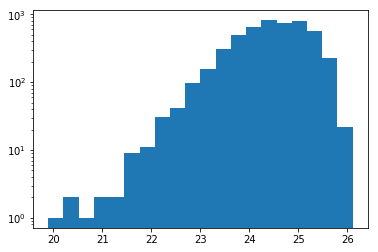

In [7]:
plt.yscale('log', nonposy='clip')
plt.hist(p.mag_r, bins = 20)

(array([ 233.,  251.,  229.,  251.,  246.,  239.,  252.,  256.,  264.,
         243.,  255.,  260.,  242.,  250.,  280.,  253.,  247.,  252.,
         226.,  264.]),
 array([  8.38690177e-04,   3.14930623e-01,   6.29022556e-01,
          9.43114489e-01,   1.25720642e+00,   1.57129835e+00,
          1.88539029e+00,   2.19948222e+00,   2.51357415e+00,
          2.82766609e+00,   3.14175802e+00,   3.45584995e+00,
          3.76994188e+00,   4.08403382e+00,   4.39812575e+00,
          4.71221768e+00,   5.02630962e+00,   5.34040155e+00,
          5.65449348e+00,   5.96858541e+00,   6.28267735e+00]),
 <a list of 20 Patch objects>)

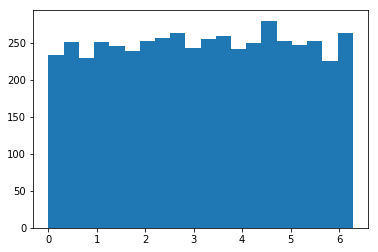

In [8]:
plt.hist(p.M, bins = 20)

(array([ 242.,  205.,  250.,  242.,  249.,  299.,  234.,  289.,  220.,
         235.,  269.,  259.,  251.,  245.,  267.,  228.,  263.,  255.,
         237.,  254.]),
 array([  1.81798482e-03,   3.15871979e-01,   6.29925974e-01,
          9.43979968e-01,   1.25803396e+00,   1.57208796e+00,
          1.88614195e+00,   2.20019595e+00,   2.51424994e+00,
          2.82830393e+00,   3.14235793e+00,   3.45641192e+00,
          3.77046592e+00,   4.08451991e+00,   4.39857391e+00,
          4.71262790e+00,   5.02668190e+00,   5.34073589e+00,
          5.65478988e+00,   5.96884388e+00,   6.28289787e+00]),
 <a list of 20 Patch objects>)

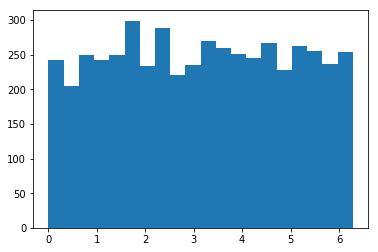

In [9]:
plt.hist(p.arg, bins = 20)

(array([ 275.,  237.,  237.,  276.,  232.,  280.,  239.,  262.,  236.,
         234.,  256.,  254.,  261.,  288.,  232.,  277.,  211.,  227.,
         235.,  244.]),
 array([  4.62627816e-04,   3.14587213e-01,   6.28711799e-01,
          9.42836384e-01,   1.25696097e+00,   1.57108556e+00,
          1.88521014e+00,   2.19933473e+00,   2.51345931e+00,
          2.82758390e+00,   3.14170848e+00,   3.45583307e+00,
          3.76995765e+00,   4.08408224e+00,   4.39820682e+00,
          4.71233141e+00,   5.02645599e+00,   5.34058058e+00,
          5.65470517e+00,   5.96882975e+00,   6.28295434e+00]),
 <a list of 20 Patch objects>)

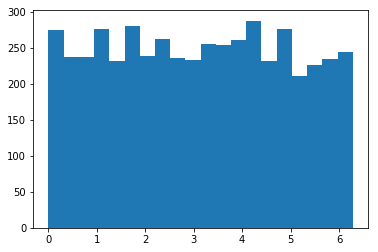

In [10]:
plt.hist(p.node, bins = 20)

(array([ 238.,  232.,  261.,  272.,  259.,  255.,  246.,  218.,  266.,
         247.,  248.,  251.,  250.,  235.,  262.,  238.,  251.,  256.,
         243.,  265.]),
 array([  4.96541349e-04,   3.14597268e-01,   6.28697994e-01,
          9.42798720e-01,   1.25689945e+00,   1.57100017e+00,
          1.88510090e+00,   2.19920163e+00,   2.51330235e+00,
          2.82740308e+00,   3.14150380e+00,   3.45560453e+00,
          3.76970526e+00,   4.08380598e+00,   4.39790671e+00,
          4.71200744e+00,   5.02610816e+00,   5.34020889e+00,
          5.65430961e+00,   5.96841034e+00,   6.28251107e+00]),
 <a list of 20 Patch objects>)

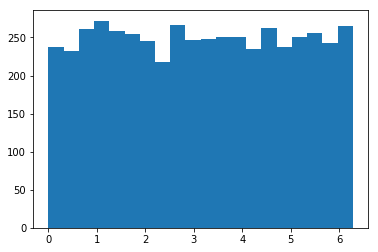

In [11]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([  19.,   54.,   83.,  135.,  236.,  306.,  341.,  399.,  414.,
         420.,  468.,  425.,  358.,  380.,  314.,  243.,  179.,  125.,
          68.,   26.]),
 array([ 0.53406353,  0.7891383 ,  1.04421307,  1.29928785,  1.55436262,
         1.80943739,  2.06451217,  2.31958694,  2.57466171,  2.82973648,
         3.08481126,  3.33988603,  3.5949608 ,  3.85003558,  4.10511035,
         4.36018512,  4.61525989,  4.87033467,  5.12540944,  5.38048421,
         5.63555899]),
 <a list of 20 Patch objects>)

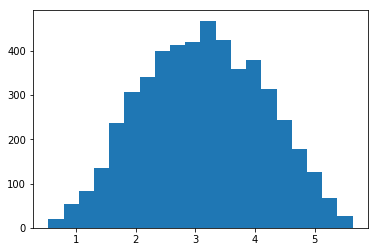

In [12]:
plt.hist(p.phi, bins = 20)

In [13]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [14]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

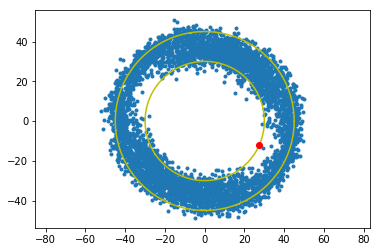

In [15]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

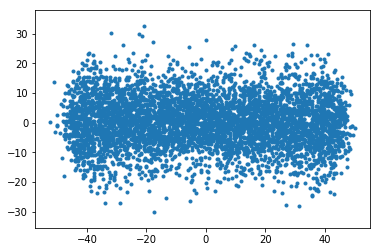

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

In [17]:
def buildmap(obj_ra, obj_dec, ecliptic_plots=True):
    lon, lat = define_footprint(ecliptic_plots=ecliptic_plots) 
#    lon2, lat2 = define_footprint(polydef='poly_bliss_p9.txt', ecliptic_plots=ecliptic_plots) 
    m = Basemap(lon_0=0, projection='moll', celestial=True)
    x, y = m( lon, lat )
#    x2,y2 = m(lon2, lat2)
    xy = zip(x,y)
#    xy2 = zip(x2,y2)
    foot = patches.Polygon( xy, facecolor='cornflowerblue', edgecolor=None, alpha=0.4 )
#    foot2 = patches.Polygon( xy2, facecolor='lightpink', edgecolor=None, alpha=0.4 )
    plt.gca().add_patch(foot)
#    plt.gca().add_patch(foot2)
    fields = SNfields()
    for f in fields:
        if ecliptic_plots:
            ecl = ephem.Ecliptic(ephem.Equatorial(f.a_ra, f.a_dec))
            lon = ecl.lon if ecl.lon<ephem.degrees('180') else ecl.lon-2*np.pi    
            m.tissot(lon*180/np.pi, ecl.lat*180/np.pi, 1.05, 100, facecolor='g', alpha=0.5)
        else:
            ra = f.a_ra if f.a_ra<ephem.degrees('180') else f.a_ra-2*np.pi
            m.tissot(ra*180/np.pi, f.a_dec*180/np.pi, 1.05, 100, facecolor='r', alpha=0.5)
    obj_ra = obj_ra*180/np.pi
    obj_dec = obj_dec*180/np.pi
    for i in range(len(obj_ra)):
        m.scatter(obj_ra[i], obj_dec[i],3,marker='.',color='k', latlon=True)
    m.drawmapboundary()
    parallels = np.arange(-180.,181,20.)
    m.drawparallels(parallels,labels=[False,True,True,False], alpha=0.4)
    meridians = np.arange(-180.,181.,20.)
    m.drawmeridians(meridians, alpha=0.4)
    return m

/Users/edward/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.

/Users/edward/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

/Users/edward/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



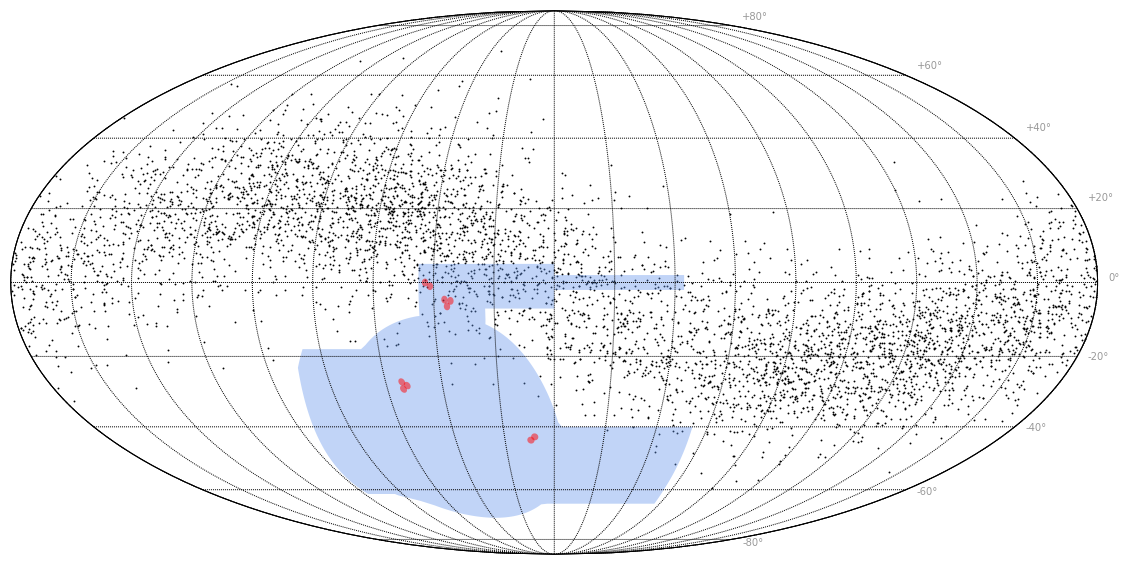

In [18]:
plt.figure(figsize=(20,10))
m = buildmap(p.ra, p.dec, ecliptic_plots=False)

In [19]:
plutinos = Scatter3d(x=p.X, y=p.Y, z=p.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=p.x_n, y=p.y_n, z=p.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[plutinos, sun, neptune])
py.iplot(fig)

In [20]:
t = trojan(size = 5000, mjd=57023)

(array([ 225.,  216.,  211.,  217.,  219.,  191.,  209.,  223.,  201.,
         216.,  218.,  212.,  216.,  195.,  236.,  191.,  175.,  213.,
         205.,  200.]),
 array([ 29.90003285,  29.91252518,  29.92501751,  29.93750984,
         29.95000216,  29.96249449,  29.97498682,  29.98747915,
         29.99997147,  30.0124638 ,  30.02495613,  30.03744846,
         30.04994078,  30.06243311,  30.07492544,  30.08741777,
         30.09991009,  30.11240242,  30.12489475,  30.13738708,  30.1498794 ]),
 <a list of 20 Patch objects>)

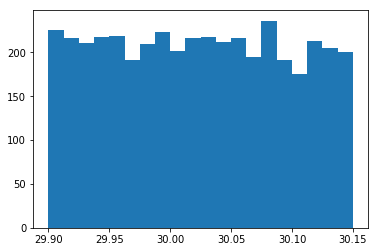

In [21]:
plt.hist(t.a, bins = 20)

(array([ 295.,  358.,  383.,  459.,  429.,  432.,  390.,  322.,  316.,
         263.,  187.,  132.,   82.,   55.,   42.,   17.,   17.,    6.,
           2.,    2.]),
 array([  2.18934045e-05,   9.03288357e-03,   1.80438737e-02,
          2.70548639e-02,   3.60658541e-02,   4.50768442e-02,
          5.40878344e-02,   6.30988246e-02,   7.21098147e-02,
          8.11208049e-02,   9.01317951e-02,   9.91427852e-02,
          1.08153775e-01,   1.17164766e-01,   1.26175756e-01,
          1.35186746e-01,   1.44197736e-01,   1.53208726e-01,
          1.62219716e-01,   1.71230707e-01,   1.80241697e-01]),
 <a list of 20 Patch objects>)

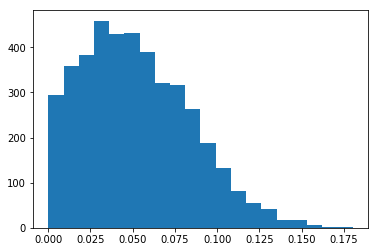

In [22]:
plt.hist(t.e, bins = 20)

(array([ 200.,  485.,  611.,  707.,  632.,  498.,  366.,  286.,  175.,
         101.,   54.,   42.,   13.,    8.,    4.,    6.,    0.,    0.,
           0.,    1.]),
 array([  0.3066018 ,   3.6925634 ,   7.07852501,  10.46448661,
         13.85044822,  17.23640982,  20.62237143,  24.00833304,
         27.39429464,  30.78025625,  34.16621785,  37.55217946,
         40.93814106,  44.32410267,  47.71006427,  51.09602588,
         54.48198749,  57.86794909,  61.2539107 ,  64.6398723 ,  68.02583391]),
 <a list of 20 Patch objects>)

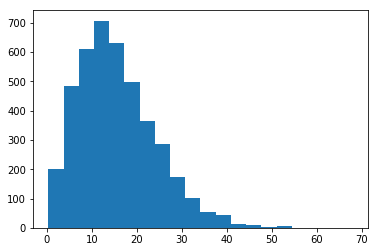

In [23]:
plt.hist(t.i*180/np.pi, bins = 20)

(array([  36.,  131.,  226.,  291.,  358.,  381.,  387.,  339.,  299.,
         299.,  276.,  260.,  176.,  197.,  136.,  133.,  105.,   80.,
          53.,   26.]),
 array([  5.12655555,   6.11449857,   7.10244159,   8.09038461,
          9.07832763,  10.06627065,  11.05421367,  12.04215668,
         13.0300997 ,  14.01804272,  15.00598574,  15.99392876,
         16.98187178,  17.9698148 ,  18.95775782,  19.94570084,
         20.93364386,  21.92158688,  22.9095299 ,  23.89747291,  24.88541593]),
 <a list of 20 Patch objects>)

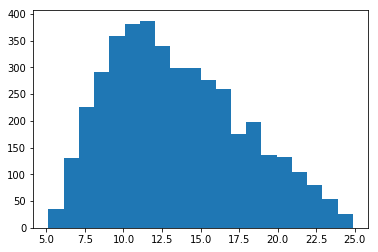

In [24]:
plt.hist(t.amp*180/np.pi, bins = 20)

(array([ 391.,  906.,  765.,   28.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,   35.,  759.,
         898.,  407.]),
 array([  12.82381119,   27.24501312,   41.66621505,   56.08741698,
          70.50861891,   84.92982084,   99.35102277,  113.7722247 ,
         128.19342663,  142.61462856,  157.03583049,  171.45703242,
         185.87823435,  200.29943628,  214.72063821,  229.14184015,
         243.56304208,  257.98424401,  272.40544594,  286.82664787,
         301.2478498 ]),
 <a list of 20 Patch objects>)

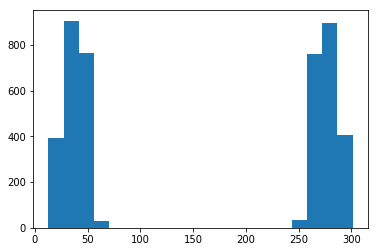

In [25]:
plt.hist((t.phi+t.lambda_N)%(2*np.pi)*180/np.pi, bins = 20)

(array([  2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          9.00000000e+00,   1.40000000e+01,   2.40000000e+01,
          3.30000000e+01,   4.80000000e+01,   7.00000000e+01,
          1.29000000e+02,   2.60000000e+02,   3.98000000e+02,
          6.67000000e+02,   9.90000000e+02,   1.05800000e+03,
          4.28000000e+02,   5.40000000e+01]),
 array([ 20.26505251,  20.51378812,  20.76252373,  21.01125935,
         21.25999496,  21.50873057,  21.75746618,  22.0062018 ,
         22.25493741,  22.50367302,  22.75240863,  23.00114425,
         23.24987986,  23.49861547,  23.74735108,  23.9960867 ,
         24.24482231,  24.49355792,  24.74229353,  24.99102915,  25.23976476]),
 <a list of 20 Patch objects>)

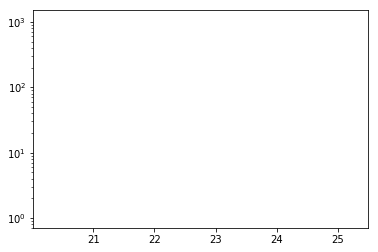

In [26]:
plt.yscale('log')
plt.hist(t.mag_r, bins = 20)

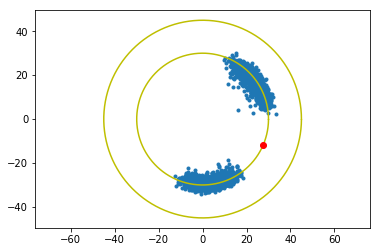

In [27]:
plt.axis('equal')
plt.scatter(t.X,t.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(t.x_n, t.y_n, 'ro')

In [28]:
trojan = Scatter3d(x=t.X, y=t.Y, z=t.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=t.x_n, y=t.y_n, z=t.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[trojan, sun, neptune])
py.iplot(fig)

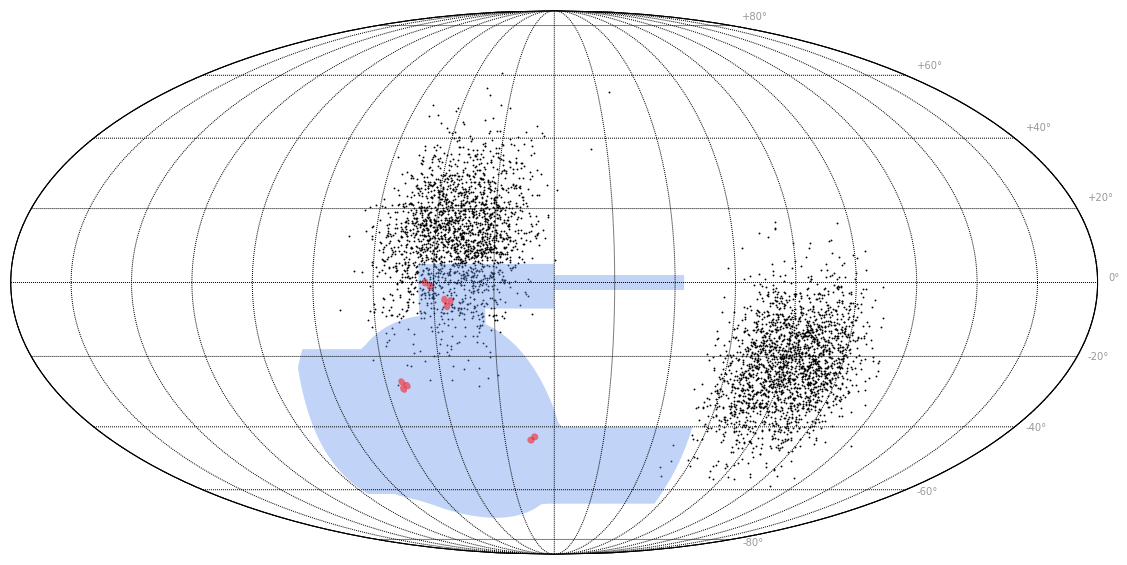

In [29]:
plt.figure(figsize=(20,10))
m = buildmap(t.ra, t.dec, ecliptic_plots=False)

In [30]:
two = twotino(size = 5000, mjd=57023, e_c = 0.4, amp_c = 3, amp_max = 5, amp_min = 0)

(array([ 127.,  339.,  484.,  532.,  618.,  614.,  522.,  483.,  368.,
         290.,  209.,  150.,  100.,   73.,   36.,   22.,   22.,    7.,
           2.,    2.]),
 array([  0.18156117,   1.40878461,   2.63600805,   3.86323149,
          5.09045493,   6.31767837,   7.54490181,   8.77212525,
          9.99934869,  11.22657213,  12.45379557,  13.68101901,
         14.90824245,  16.13546588,  17.36268932,  18.58991276,
         19.8171362 ,  21.04435964,  22.27158308,  23.49880652,  24.72602996]),
 <a list of 20 Patch objects>)

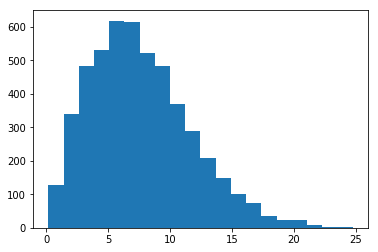

In [31]:
plt.hist((two.i)*180/np.pi, bins = 20)

(array([ 275.,  317.,  387.,  292.,  313.,  340.,  265.,  117.,   58.,
          53.,   52.,   50.,  161.,  260.,  383.,  363.,  297.,  378.,
         353.,  286.]),
 array([   7.51823235,   22.46700748,   37.41578262,   52.36455776,
          67.31333289,   82.26210803,   97.21088317,  112.1596583 ,
         127.10843344,  142.05720858,  157.00598371,  171.95475885,
         186.90353399,  201.85230912,  216.80108426,  231.7498594 ,
         246.69863453,  261.64740967,  276.5961848 ,  291.54495994,
         306.49373508]),
 <a list of 20 Patch objects>)

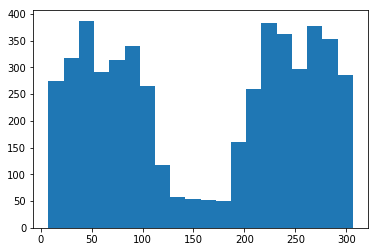

In [ ]:
plt.hist((two.phi+two.lambda_N)%(2*np.pi)*180/np.pi, bins = 20)

In [ ]:
plt.yscale('log')
plt.hist(t.mag_r, bins = 20)

In [ ]:
plt.axis('equal')
plt.scatter(two.X[two.phi0 == 0],two.Y[two.phi0 == 0], marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

In [ ]:
plt.axis('equal')
plt.scatter(two.X[two.phi0 != 0],two.Y[two.phi0 != 0], marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

In [ ]:
plt.axis('equal')
plt.scatter(two.X,two.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

In [ ]:
twotinos = Scatter3d(x=two.X, y=two.Y, z=two.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='twotinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=two.x_n, y=two.y_n, z=two.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[twotinos, sun, neptune])
py.iplot(fig)

In [ ]:
plt.figure(figsize=(20,10))
m = buildmap(two.ra[two.phi0 == 0], two.dec[two.phi0 == 0], ecliptic_plots=False)

In [ ]:
plt.figure(figsize=(20,10))
m = buildmap(two.ra[two.phi0 != 0], two.dec[two.phi0 != 0], ecliptic_plots=False)